In [13]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from transformers import AutoModel, BertTokenizerFast
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

In [2]:
# Load data
df = pd.read_csv('drive/MyDrive/sentiment.csv')
df.head()

,sentence,label
0,Ok brokeback mountain is such a horrible movie.,0
1,Brokeback Mountain was so awesome.,1
2,friday hung out with kelsie and we went and sa...,0
3,I am going to start reading the Harry Potter s...,1
4,"Is it just me, or does Harry Potter suck?...",0


In [3]:
# Split the data into train, validation and test data
train_text, temp_text, train_labels, temp_labels = train_test_split(
    df['sentence'],
    df['label'],
    random_state=2024,
    test_size=0.3,
    stratify=df['label'])
val_text, test_text, val_labels, test_labels = train_test_split(
    temp_text,
    temp_labels,
    random_state=2024,
    test_size=0.5,
    stratify=temp_labels)

In [4]:
# Load model and tokenizer
bert = AutoModel.from_pretrained('bert-base-uncased')
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

(array([1467.,  721.,  570.,  533.,  159.,  218.,  117.,   61.,  115.,
           6.]),
 array([ 3. ,  6.5, 10. , 13.5, 17. , 20.5, 24. , 27.5, 31. , 34.5, 38. ]),
 <BarContainer object of 10 artists>)

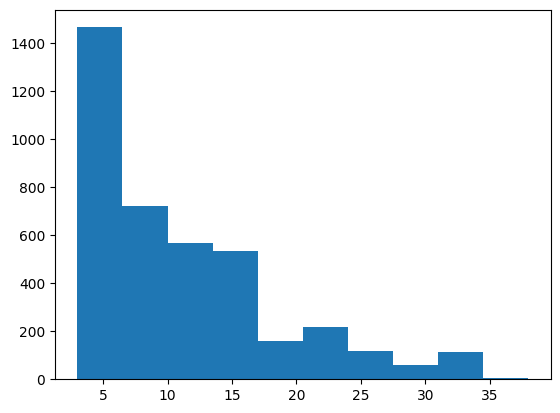

In [5]:
# Determine padding length
train_lens = [len(i.split()) for i in train_text]
plt.hist(train_lens)
# val_lens = [len(i.split()) for i in val_text]
# test_lens = [len(i.split()) for i in test_text]

# max_len = 0
# for text in train_text:
#     input_ids = tokenizer.encode(text, add_special_tokens=True)
#     max_len = max(max_len, len(input_ids))

In [11]:
# tokenize and encode sequences
pad_len = 17
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length=pad_len,
    truncation=True,
    padding=True
    )
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length=pad_len,
    truncation=True,
    padding=True
    )
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length=pad_len,
    truncation=True,
    padding=True
    )

tokens_train.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

In [10]:
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

In [14]:
# Defining the model (freeze pretained layers and add new layers)
# Freeze the pretrained layers
for param in bert.parameters():
    param.requires_grad = False

# Define new layers
class BERT_architecture(nn.Module):
  """
  BERT_architecture
  """
  def __init__(self, bert):
    """
    Constructor
    """
    super(BERT_architecture, self).__init__()
    self.bert = bert
    # dropout layer
    self.dropout = nn.Dropout(p=0.1)
    # relu activation function
    self.relu =  nn.ReLU()
    # dense layer
    self.fc1 = nn.Linear(768,512)
    self.fc2 = nn.Linear(512,2) # output layer
    # softmax activation function
    self.softmax = nn.LogSoftmax(dim=1)

  # Define the forward pass
  def forward(self, sent_id, mask):
    """
    Forward pass
    """
    # pass the inputs to the model
    _, cls_hs = self.bert(sent_id, attention_mask=mask)
    x = self.fc1(cls_hs)
    x = self.relu(x)
    x = self.dropout(x)
    x = self.fc2(x) # output layer
    x = self.softmax(x)
    return x

In [15]:
# Add an optimizer to enhance the performance
model = BERT_architecture(bert)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5) # lr is learning rate

In [ ]:
# Function to train the model
def train(model, train_seq, train_mask, train_y, val_seq, val_mask, val_y):
  """
  Train the model
  """
  model.train()
  train_